# Valencian Real Estate Market Price Analyis

This notebooks is used to analyze the real estate prices in Valencia. First data is queries via the Idealista API, after that the received data is analyzed.

Questions:

1. What are the average prices in the different districts/neighborhoods of Valencia?
2. What area in Valencia has the best raito rent/sale price?
3. What are the renting prices in the different districts/neighborhoods of Valencia?
4. Are sale prices for flats in the city centre of Valencia rising or falling over time?
5. How long are sale listings publicated before the flat is bought?

Wit that knowledge the following questions can be answered viewing listings:
- Is the price per area of a certain flat good?



## Configure

In [1]:
# API call
import base64
import requests
import json

# standard libs
import os
import re
from pathlib import Path
import json
from datetime import datetime
import getpass
import configparser

# data retrieval
import boto3
from botocore.exceptions import ClientError

# data analysis 
import pandas as pd
pd.set_option('display.max_columns', None)

# data plotting
import seaborn as sns
from matplotlib import pyplot as plt



In [2]:
# initialize config parser
config = configparser.ConfigParser()
config.read('valenciaHousingAnalysis.cfg')

['valenciaHousingAnalysis.cfg']

In [13]:
key = config.get("API","KEY");
secret = config.get('API','SECRET');

## Data Gathering

## Code for AWS Lambda Function

In [6]:
def get_oauth_token(key, secret):
    '''Function creates personalised idealista token from key secret pair.'''
    
    message = key + ":" + secret # Combine the API key and  secret to personalised message
    auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii") # Encode the message   
    headers = {"Authorization" : auth, "Content-Type" : "application/x-www-form-urlencoded;charset=UTF-8"} # Define headers   
    params = {"grant_type" : "client_credentials", "scope" : "read"} # Define request params
    request = requests.post("https://api.idealista.com/oauth/token", headers=headers, params=params)  # Perform the request with the api url, headers and params
    token = json.loads(request.text)['access_token'] # Obtain  personalised token, as a json  

    return token

In [7]:
# function to create search url
def define_request_url(operation):
    '''Function combines search parameters with the url to create search url for request.'''
    
    config = {
       'base_url': 'https://api.idealista.com/3.5/',
       'country': 'es',
       'max_items' : '50',
       'order' : 'distance',
       'center' : '39.4693441,-0.379561',
       'distance' : '1500',
       'property_type' : 'homes',
       'sort' : 'asc',
       'minSize' : '100',
       'maxSize' : '160',
       'elevator' : 'True',
       'airConditioning' : 'True',
       'preservation' : 'good',
       'language': 'en'
       }
    
    url = (config['base_url'] 
           + config['country'] 
           +'/search?operation=' + operation 
           +'&maxItems=' + config['max_items'] 
           + '&order=' + config['order'] 
           + '&center=' + config['center'] 
           + '&distance=' + config['distance'] 
           + '&propertyType=' + config['property_type'] 
           + '&sort=' + config['sort'] 
           + '&minSize=' +config['minSize']
           + '&maxSize=' + config['maxSize']
           + '&numPage=%s' 
           + '&elevator=' + config['elevator'] 
           #+'&airConditioning' + config['airConditioning']
           + '&preservation' + config['preservation'] 
           + '&language=' + config['language'])
    
    return url

In [8]:
# function to request data from idealista API
def query_api(key, secret, url):  
    '''Function uses requests package to query the idealista API with given token and search url.'''
    
    token = get_oauth_token(key, secret) # get the personalised token  
    headers = {'Content-Type': 'Content-Type: multipart/form-data;', # define the search headers  
               'Authorization' : 'Bearer ' + token}

    content = requests.post(url, headers = headers) # return the content from the request  

    if content.text == '': # Transform the result as a json file
        print('Error: Exceeded API call limit or wrong parameters')
        result = None
    else: result = content.text #json.loads(content.text)   

    return result

In [17]:
# request data and loop through all pages

now=datetime.now()
date_time=now.strftime('%Y%m%d_%H%M%S')
    
url = define_request_url('rent') # 'sale'

page = 1
total_pages = 1 # 5

while page <= 1: #total_pages:

    url_of_page = url %(page) # Add the pagination to the url
    
    page_result_json = query_api(key_pau, secret_pau, url_of_page) # Get the search results
    page_result = json.loads(page_result_json)
    total_pages = page_result['totalPages'] # Get amount of pages
    
    filename='listings_' + date_time + '_' + str(page) + '.json'
    
    """
    s3.put_object(
        Bucket=bucket, 
        Key=filename,
        Body=page_result_json
        )
    """
    
    page += 1


In [18]:
total_pages

6

The AWS Lamba function downloads once per week all available listings in a defined area of Valencia.

The following filter are applied when requesting the idealista API:

* 'property_type' : 'homes',
* 'center' : '39.4693441,-0.379561',
* 'distance' : '1500',
* 'minSize' : '100',
* 'maxSize' : '160',
* 'elevator' : 'True',
* 'preservation' : 'good',
* 'order' : 'distance',
* 'sort' : 'asc',
       

![search radius](images/SearchRadius.png "Search Radius")


### Download json files from S3 

After the AWS Lambda function requested data via the idealista API it saved it as JSON files in an S3 bucket. The next step is to download the data from the S3 bucket to be able to analyze it locally.

In [ ]:
# Check internet connection
requests.get("https://aws.amazon.com/de/")

<Response [200]>

In [45]:
# AWS Secrets
aws_key_id = getpass.getpass('AWS Access Key ID')
aws_secret = getpass.getpass('AWS Secret')

In [46]:
# configure s3 client

region = 'eu-central-1'
bucket = 'valencialistings'

s3_client = boto3.client('s3',
                        region_name=region,
                        aws_access_key_id=aws_key_id,
                        aws_secret_access_key=aws_secret,
                        ) 

In [55]:
# create list with names of all locally available files
local_files = os.listdir('./data/s3/')

# download all json files that are not already locally available
for key in s3_client.list_objects(Bucket=bucket)['Contents']:
    
    # if file already downloaded, skip 
    if key['Key'] in local_files:
        #print(f"File {key['Key']} alreaday in local folder")
        continue
    
    else:
        # download csv file written before
        s3_client.download_file(bucket, key['Key'], f"data/s3/{key['Key']}")
        #print(F"Successfully ownloaded file {key['Key']} from S3")

File rent_20230409_120044_1.json alreaday in local folder
File rent_20230409_120044_2.json alreaday in local folder
File rent_20230409_120044_3.json alreaday in local folder
File rent_20230409_120044_4.json alreaday in local folder
File rent_20230409_120044_5.json alreaday in local folder
File rent_20230409_120044_6.json alreaday in local folder
File sale_20230409_120044_1.json alreaday in local folder
File sale_20230409_120044_10.json alreaday in local folder
File sale_20230409_120044_11.json alreaday in local folder
File sale_20230409_120044_12.json alreaday in local folder
File sale_20230409_120044_13.json alreaday in local folder
File sale_20230409_120044_14.json alreaday in local folder
File sale_20230409_120044_15.json alreaday in local folder
File sale_20230409_120044_16.json alreaday in local folder
File sale_20230409_120044_17.json alreaday in local folder
File sale_20230409_120044_2.json alreaday in local folder
File sale_20230409_120044_3.json alreaday in local folder
File s

### Analyze data

In [7]:
# read one json into dataframe

""" 
with open('./data/s3/listings_20230118_174107_1.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['elementList'])
df.head()
"""


# read all json into dataframe
df_all_pages = pd.DataFrame()
pathlist = Path('./data/s3/').glob('**/*.json')

for path in pathlist:
     
     path_str = str(path) # because path is object not string
     #print(path_str)
     

     m = re.search('data/s3/listings_([0-9]{8})_([0-9]{6})_([0-9]{1}).json', path_str)
     if m:
          found_1 = m.group(1)
          found_2 = m.group(2)
          found_3 = m.group(3)
     # print(found_1 + ' ' + found_2+ ' ' + found_3)
     
     date_time_obj = datetime.strptime(found_1, '%Y%m%d')

     with open('./' + path_str) as json_data:
          data = json.load(json_data)
          df_page = pd.DataFrame(data['elementList'])
          df_page['dateDownload']= date_time_obj
          df_all_pages = pd.concat([df_all_pages, df_page]) 


In [8]:
# see dataframe with all data         
df_all_pages.head(n=3)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,bathrooms,address,province,municipality,district,country,neighborhood,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,superTopHighlight,parkingSpace,dateDownload,labels,newDevelopmentFinished
0,95537628,https://img3.idealista.com/blur/WEB_LISTING/0/...,VTA/128075,14,3,270000.0,flat,sale,108.0,True,4,2,"Cádiz, 5",València,València,L'Eixample,es,Russafa,39.463984,-0.374817,True,https://www.idealista.com/inmueble/95537628/,721,ED real estate presenta este clásico piso en e...,False,good,False,True,2500.0,{'typology': 'flat'},"{'subtitle': 'Russafa, València', 'title': 'Pi...",False,False,False,False,False,False,NaN,2023-03-19,NaN,NaN
1,98422766,https://img3.idealista.com/blur/WEB_LISTING/0/...,NaN,43,5,370000.0,flat,sale,134.0,True,4,2,Calle Doctor Gil y Morte,València,València,Extramurs,es,Arrancapins,39.462945,-0.380978,False,https://www.idealista.com/inmueble/98422766/,721,Esta hermosa vivienda seminueva del año 2000 e...,False,good,False,True,2761.0,{'typology': 'flat'},"{'subtitle': 'Arrancapins, València', 'title':...",True,False,False,False,False,False,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",2023-03-19,NaN,NaN
2,100314856,https://img3.idealista.com/blur/WEB_LISTING/0/...,DD397,37,5,397000.0,penthouse,sale,145.0,True,2,2,barrio Arrancapins,València,València,Extramurs,es,Arrancapins,39.465302,-0.386153,False,https://www.idealista.com/inmueble/100314856/,722,"Si esta buscando para vivir con tu familia, pa...",True,good,False,True,2738.0,"{'typology': 'flat', 'subTypology': 'penthouse'}","{'subtitle': 'Arrancapins, València', 'title':...",True,False,False,False,False,False,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",2023-03-19,NaN,NaN


In [9]:
df_all_pages.count()

propertyCode              1074
thumbnail                 1070
externalReference          911
numPhotos                 1074
floor                     1057
price                     1074
propertyType              1074
operation                 1074
size                      1074
exterior                  1074
rooms                     1074
bathrooms                 1074
address                   1074
province                  1074
municipality              1074
district                  1074
country                   1074
neighborhood              1074
latitude                  1074
longitude                 1074
showAddress               1074
url                       1074
distance                  1074
description               1072
hasVideo                  1074
status                    1074
newDevelopment            1074
hasLift                   1074
priceByArea               1074
detailedType              1074
suggestedTexts            1074
hasPlan                   1074
has3DTou

How many listings are downloaded every week?
The idealista API allows 100 requests per month, with 50 listings per request. In total this results into a maximum of 5000 listings per month.

In [12]:
df_download_date = \
    df_all_pages \
        .groupby(by=['dateDownload', 'operation']) \
        .agg({'propertyCode': ['count']}) \
        .reset_index() \

df_download_date.head(n=15)

,dateDownload,operation,propertyCode
,,,count
0,2023-03-19,rent,257
1,2023-03-19,sale,817


Let's get an overview of the mean price per area by neighborhood over all real estate listings:


In [43]:
# Statistics per neigbourhood including all non-duplicates
    #.drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last')
df_neighborhoods = \
    df_all_pages \
        .groupby(by=['district', 'neighborhood', 'operation']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_neighborhoods.columns = ['district', 'neighborhood', 'operation', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']    

# join sales and rent information by for neighborhood
df_neighborhoods_rent_vs_sale = df_neighborhoods[(df_neighborhoods.operation == 'sale')].merge(
    df_neighborhoods[(df_neighborhoods.operation == 'rent')], 
    on=['neighborhood', 'district'], how='inner', suffixes=('_sale', '_rent')) \
    .drop(columns=['operation_sale', 'operation_rent']) \
    
df_neighborhoods_rent_vs_sale['mean_sales_price_by_rent_ratio'] = df_neighborhoods_rent_vs_sale.eval('mean_priceByArea_sale / mean_priceByArea_rent')

df_neighborhoods_rent_vs_sale = df_neighborhoods_rent_vs_sale[
    ['district', 'neighborhood', 
     'mean_priceByArea_sale', 'mean_priceByArea_rent', 'mean_sales_price_by_rent_ratio',
     'mean_size_sale', 'mean_size_rent',
     'count_listings_sale', 'count_listings_rent',
     'mean_prize_sale', 'mean_prize_rent']]

df_neighborhoods_rent_vs_sale \
    [(df_neighborhoods_rent_vs_sale['count_listings_sale'] >= 5) \
    & (df_neighborhoods_rent_vs_sale['count_listings_rent'] >= 5)] \
    .sort_values(['mean_priceByArea_sale'], ascending = [False]) \
    .head(n=60)

,district,neighborhood,mean_priceByArea_sale,mean_priceByArea_rent,mean_sales_price_by_rent_ratio,mean_size_sale,mean_size_rent,count_listings_sale,count_listings_rent,mean_prize_sale,mean_prize_rent
12,L'Eixample,El Pla del Remei,4218.477612,14.965517,281.879840,131.582090,131.620690,67,29,549537.313433,1947.862069
5,Ciutat Vella,Sant Francesc,4163.078947,16.774194,248.183553,128.644737,121.258065,76,31,526697.289474,1996.129032
1,Ciutat Vella,El Mercat,3728.833333,13.764706,270.898148,134.722222,124.294118,18,17,510611.111111,1700.000000
3,Ciutat Vella,La Seu,3634.619048,19.000000,191.295739,125.904762,139.166667,21,6,455904.761905,2666.666667
13,L'Eixample,Gran Vía,3453.040816,13.526316,255.283173,136.244898,122.789474,49,19,467081.632653,1651.315789
4,Ciutat Vella,La Xerea,3270.777778,16.181818,202.126717,136.388889,135.090909,36,11,447888.861111,2181.818182
10,Extramurs,La Roqueta,3182.891304,13.625000,233.606701,124.086957,127.625000,46,8,392065.217391,1750.000000
0,Ciutat Vella,El Carme,3054.437500,14.875000,205.340336,130.906250,119.375000,32,8,396615.593750,1736.125000
2,Ciutat Vella,El Pilar,2878.800000,16.350000,176.073394,123.700000,118.850000,10,20,358189.900000,1935.500000
14,L'Eixample,Russafa,2771.196078,13.594595,203.845437,124.029412,123.216216,102,37,343223.431373,1649.486486


Now the same aggregations, but only for flats that are similar to the one we are looking for:

In [17]:
# Statistics per district of non-duplicates with required specifics
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
df_districts = \
    df_all_pages[(df_all_pages.hasLift == True)
                 & (df_all_pages.floor != '1')
                 & (df_all_pages.size > 120)
                 & (df_all_pages.rooms >= 2)
                 & (df_all_pages.bathrooms >= 2)
                 & (df_all_pages.price < 400000.0)
                 & (df_all_pages.price > 300000.0)] \
        .groupby(by=['district', 'neighborhood', 'operation']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_districts.columns = ['district', 'neighborhood', 'operation', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
df_districts.sort_values(['mean_priceByArea'], ascending = [False]) \
    .head(n=60)
    


,district,neighborhood,operation,count_listings,mean_priceByArea,mean_size,mean_prize
7,Extramurs,La Petxina,sale,28,3397.500000,113.214286,378375.000000
2,Ciutat Vella,La Seu,sale,1,3200.000000,100.000000,320000.000000
10,L'Eixample,Gran Vía,sale,8,3090.500000,117.625000,359625.000000
8,Extramurs,La Roqueta,sale,10,2985.600000,123.400000,363500.000000
5,Extramurs,Arrancapins,sale,57,2867.087719,130.385965,369068.403509
4,Ciutat Vella,Sant Francesc,sale,8,2857.750000,131.000000,372500.000000
11,L'Eixample,Russafa,sale,35,2732.257143,132.742857,357620.000000
3,Ciutat Vella,La Xerea,sale,14,2726.357143,119.357143,321071.357143
0,Ciutat Vella,El Carme,sale,14,2698.928571,140.142857,377857.071429
1,Ciutat Vella,El Mercat,sale,2,2607.500000,140.500000,364500.000000


In [19]:
# Statistics of non-duplicates over time
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
df_city_prices_time_series = \
    df_all_pages \
        .groupby(by=['dateDownload', 'operation']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_city_prices_time_series.columns = ['dateDownload', 'operation', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
df_city_prices_time_series \
    .sort_values(['dateDownload']) \
    .head(n=60)

,dateDownload,operation,count_listings,mean_priceByArea,mean_size,mean_prize
0,2023-03-19,rent,257,14.046693,124.501946,1735.642023
1,2023-03-19,sale,817,3021.809058,127.777234,384982.468788


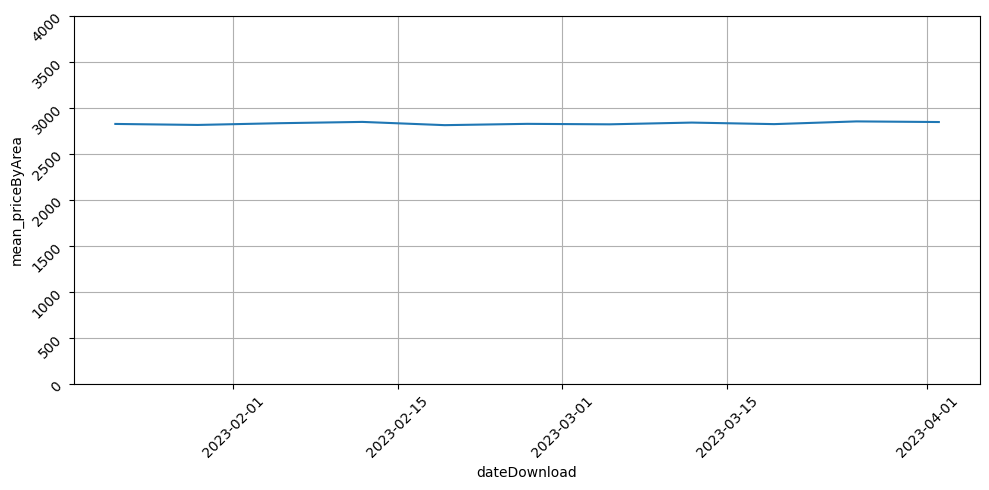

In [91]:
# plot time series of mean price by area in Valencia
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

ax = sns.lineplot(data=df_city_prices_time_series, x="dateDownload", y="mean_priceByArea")
ax.set_ylim(0, 4000)
ax.tick_params(rotation=45)

plt.grid()
plt.show()

In [20]:

# Statistics per district including all non-duplicates
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last')
df_districts_prices_time_series  = \
    df_all_pages \
        .groupby(by=['district', 'dateDownload', 'operation']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \
            


df_districts_prices_time_series.columns = ['district', 'operation', 'dateDownload', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']

df_districts_prices_time_series = df_districts_prices_time_series[df_districts_prices_time_series.count_listings > 50]

df_districts_prices_time_series \
    .sort_values(['district', 'dateDownload']) \
    .head(n=60)

,district,operation,dateDownload,count_listings,mean_priceByArea,mean_size,mean_prize
1,Ciutat Vella,2023-03-19,rent,93,16.043011,123.924731,1971.817204
2,Ciutat Vella,2023-03-19,sale,193,3648.279793,130.476684,472495.290155
5,Extramurs,2023-03-19,rent,54,12.240741,123.055556,1496.425926
6,Extramurs,2023-03-19,sale,283,2751.307420,125.314488,341502.109541
9,L'Eixample,2023-03-19,rent,85,14.047059,125.988235,1751.694118
10,L'Eixample,2023-03-19,sale,218,3369.261468,129.096330,434471.513761
16,Patraix,2023-03-19,sale,59,1993.271186,125.118644,248833.881356


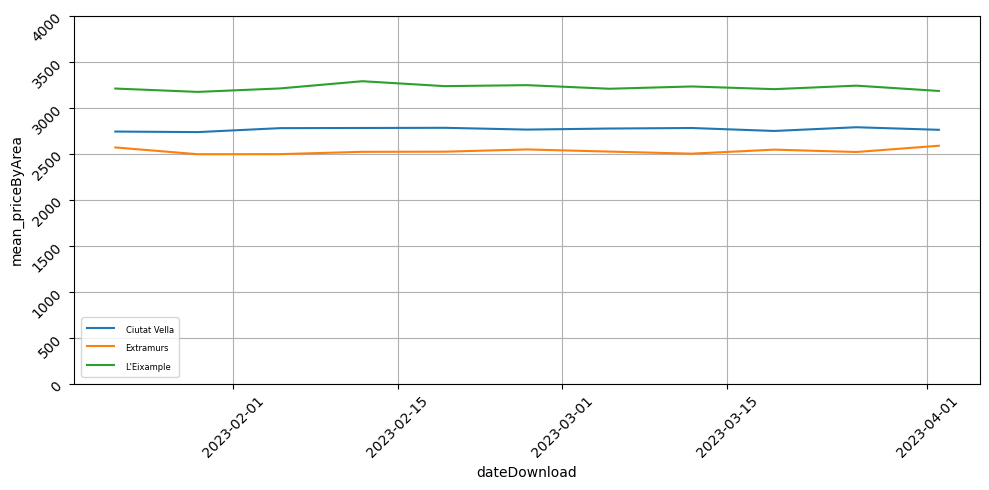

In [90]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True


ax = sns.lineplot(data=df_districts_prices_time_series, x='dateDownload', y='mean_priceByArea', hue='district')

ax.set_ylim(0, 4000)
ax.tick_params(rotation=45)
plt.legend(loc='lower left')

plt.setp(ax.get_legend().get_texts(), fontsize='6') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title

plt.grid()
plt.show()

In [ ]:
# propertyCode


## TODO

* statistics:
  * how long is a property online
  * how are single property prices behaving over time

  * calculate years for ROI